In [1]:
%matplotlib inline

import nltk
import sklearn
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, KFold, GroupKFold
from sklearn.metrics import mean_squared_error
from ydata_profiling import ProfileReport

## Load data

In [2]:
DATA_DIR = "../data/commonlit-evaluate-student-summaries/"
prompts_train = pd.read_csv(DATA_DIR + "prompts_train.csv")
summaries_train = pd.read_csv(DATA_DIR + "summaries_train.csv")
prompts_test = pd.read_csv(DATA_DIR + "prompts_test.csv")
summaries_test = pd.read_csv(DATA_DIR + "summaries_test.csv")
sample_submission = pd.read_csv(DATA_DIR + "sample_submission.csv")

In [3]:
train = summaries_train.join(prompts_train.set_index("prompt_id"), on="prompt_id", how="left")
test_data = summaries_test.join(prompts_test.set_index("prompt_id"), on="prompt_id", how="left")

In [4]:
train.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...


In [5]:
test_data.head()

,student_id,prompt_id,text,prompt_question,prompt_title,prompt_text
0,000000ffffff,abc123,Example text 1,Summarize...,Example Title 1,Heading\nText...
1,111111eeeeee,def789,Example text 2,Summarize...,Example Title 2,Heading\nText...
2,222222cccccc,abc123,Example text 3,Summarize...,Example Title 1,Heading\nText...
3,333333dddddd,def789,Example text 4,Summarize...,Example Title 2,Heading\nText...


## Data preparation

In [6]:
ProfileReport(train)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/mykyta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mykyta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
def process_text(text):
    text = text.lower()
    tokens = nltk.tokenize.word_tokenize(text)
    
    # Remove punctuation
    tokens = [word for word in tokens if word.isalnum()]

    # Remove stopwords, so rare words have more influance at content score
    tokens = [token for token in tokens if token not in stop_words]

    # Stem tokens to lower vocab size
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    return ' '.join(stemmed_tokens)

In [9]:
train['processed_prompt'] = train['prompt_text'].apply(process_text)
train['processed_text'] = train['text'].apply(process_text)

In [10]:
raw_prompt_word_cloud = WordCloud(width=800, height=400).generate(" ".join(train['prompt_text']))
processed_prompt_word_cloud = WordCloud(width=800, height=400).generate(" ".join(train['processed_prompt']))
raw_text_word_cloud = WordCloud(width=800, height=400).generate(" ".join(train['text']))
processed_text_word_cloud = WordCloud(width=800, height=400).generate(" ".join(train['processed_text']))

### Prompt word cloud:

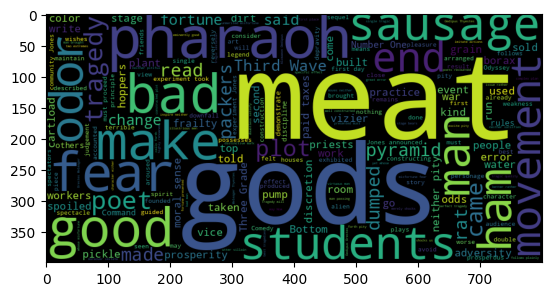

In [11]:
plt.imshow(raw_prompt_word_cloud);

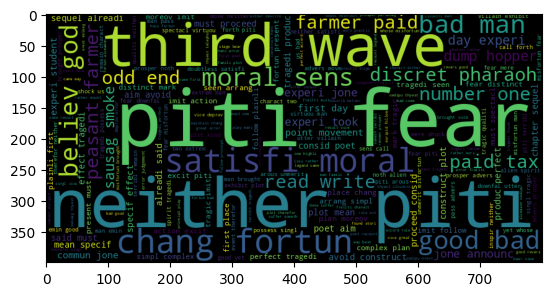

In [12]:
plt.imshow(processed_prompt_word_cloud);

### Text word cloud:

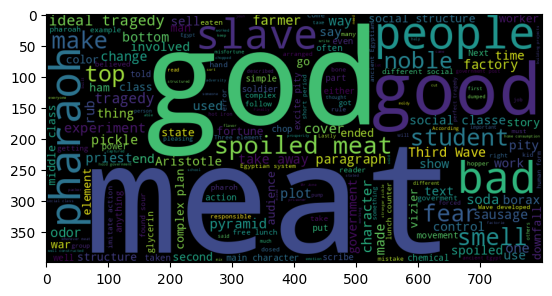

In [13]:
plt.imshow(raw_text_word_cloud);

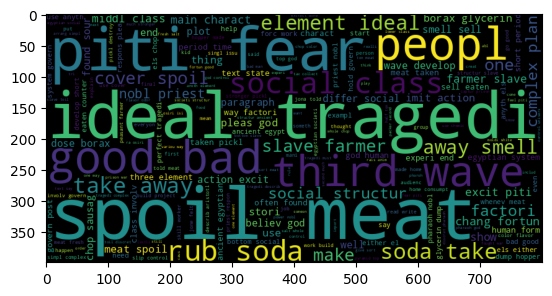

In [14]:
plt.imshow(processed_text_word_cloud);

Text processing made word distribution more even

In [15]:
train['prompt_len'] = train['processed_prompt'].apply(len)
train['text_len'] = train['processed_text'].apply(len)

In [16]:
train[['text_len', 'prompt_len', 'content', 'wording']].corr()

,text_len,prompt_len,content,wording
text_len,1.000000,0.027883,0.797507,0.539919
prompt_len,0.027883,1.000000,-0.018732,-0.087100
content,0.797507,-0.018732,1.000000,0.751380
wording,0.539919,-0.087100,0.751380,1.000000


Text len is very correlated with content score, but not with wording. Try add features that influance wording score

In [17]:
# Counting words in text to find content similarity between text and prompt
def word_overlap_count(prompt, text):
    return len([1 for word in text.split(" ") if word in prompt.split(' ')])

In [18]:
# Counting total len of quotes, because text with qoutes from prompt could have better content score
def quotes_len(text):
    return sum([len(qoute) for qoute in(re.findall(r'"([^"]*)"', text))])

In [19]:
# Counting mean word len in text, since longer word could correlate with better scores
def mean_word_len(text):
    return np.mean([len(word) for word in text.split(" ")])

In [20]:
# Texts with more unique words can have better content score
def unique_word_count(text):
    return len(set(text.split(" ")))

In [21]:
def add_all_features(df):
    if 'processed_prompt' not in df:
        df['processed_prompt'] = df['prompt_text'].apply(process_text)
    if 'processed_text' not in df:
        df['processed_text'] = df['text'].apply(process_text)
    
    df['prompt_len'] = df['processed_prompt'].apply(len)
    df['text_len'] = df['processed_text'].apply(len)
    
    df['word_overlap_count'] = df.apply(lambda row: word_overlap_count(row['processed_prompt'], row['processed_text']), axis=1)
    df['quotes_len'] = df['text'].apply(quotes_len)

    # Counting word len in prompt, because if prompt is easy then text doesn't need to have long words 
    df['prompt_mean_word_len'] = df['processed_prompt'].apply(mean_word_len)
    df['text_mean_word_len'] = df['processed_text'].apply(mean_word_len)

    # Same reason for unique words
    df['prompt_unique_word_count'] = df['processed_prompt'].apply(unique_word_count)
    df['text_unique_word_count'] = df['processed_text'].apply(unique_word_count)

In [22]:
add_all_features(train)

In [23]:
train[['text_len', 'word_overlap_count', 'quotes_len', 'text_mean_word_len', 'text_unique_word_count', 'content', 'wording']].corr()

,text_len,word_overlap_count,quotes_len,text_mean_word_len,text_unique_word_count,content,wording
text_len,1.000000,0.930002,0.617672,0.120059,0.975868,0.797507,0.539919
word_overlap_count,0.930002,1.000000,0.688027,-0.011200,0.924995,0.701668,0.360036
quotes_len,0.617672,0.688027,1.000000,-0.088748,0.608540,0.419206,0.156464
text_mean_word_len,0.120059,-0.011200,-0.088748,1.000000,0.067432,0.132739,0.151498
text_unique_word_count,0.975868,0.924995,0.608540,0.067432,1.000000,0.794251,0.520515
content,0.797507,0.701668,0.419206,0.132739,0.794251,1.000000,0.751380
wording,0.539919,0.360036,0.156464,0.151498,0.520515,0.751380,1.000000


Text len still has most influance at wording score, try using vectorization

## Vectorization

### TF-IDF
Using char analyzer and ngram_range to search for misspaling in syllabels instead of words to lower vocab size. Using tfidf vectorizer so rare syllabels (mistakes) would have higher weight

In [24]:
wording_vectorizer = TfidfVectorizer(analyzer='char', lowercase=True, strip_accents='ascii', ngram_range=(2, 4), max_features=100)

In [25]:
wording_vectorizer.fit(train['text'])

TfidfVectorizer(analyzer='char', max_features=100, ngram_range=(2, 4),
                strip_accents='ascii')

In [26]:
text_wording_vectorized = wording_vectorizer.transform(train['text']).toarray()

## Modeling
Using two models: one to predict content score and another to predict wording

In [27]:
CONTENT_FEATURES = [
    'text_len',
    'word_overlap_count',
    'quotes_len',
    'prompt_mean_word_len',
    'text_mean_word_len',
    'prompt_unique_word_count',
    'text_unique_word_count'
]

WORDING_FEATURES = ['text_len']

In [28]:
content_scaler = StandardScaler()
content_scaler.fit(train[CONTENT_FEATURES])
wording_scaler = StandardScaler()
wording_scaler.fit(train[WORDING_FEATURES])

StandardScaler()

In [29]:
# Prepare content data
train_content_sparse = np.hstack([
    content_scaler.transform(train[CONTENT_FEATURES])
])

# Prepare wording data
train_wording_sparse = np.hstack([
    text_wording_vectorized,
    wording_scaler.transform(train[WORDING_FEATURES])
])

In [30]:
models = []
models.append(('Ridge', Ridge(), Ridge()))
models.append(("RFR", RandomForestRegressor(n_jobs=-1), RandomForestRegressor(n_jobs=-1)))
models.append(('GBM', LGBMRegressor(n_jobs=-1, verbosity=-1), LGBMRegressor(n_jobs=-1, verbosity=-1)))

## Cross validations

Checking what type of cross validation better correlates with leaderboard.

Trying regular kfold, grouping by prompt_id and grouping by student_id.

Using 4 splits so all cv would have the same number and this is max number for grouping by prompt_id.

In [31]:
kfold_cv = KFold(n_splits=4)
group_kfold_cv = GroupKFold(n_splits = 4)

In [32]:
score_results = []
for model_name, content_model, wording_model in models:
    splits = []
    splits.append(("KFold", kfold_cv.split(train)))
    splits.append(("Group_KFold_Prompt", group_kfold_cv.split(train, groups=train['prompt_id'])))
    splits.append(("Group_KFold_Student", group_kfold_cv.split(train, groups=train['student_id'])))
    split_scores = {}
    for split_name, split in splits:
        scores = []
        for train_ids, test_ids in split:
            content_model.fit(train_content_sparse[train_ids], train.loc[train_ids]['content'])
            wording_model.fit(train_wording_sparse[train_ids], train.loc[train_ids]['wording'])
            
            content_pred = content_model.predict(train_content_sparse[test_ids])
            wording_pred = wording_model.predict(train_wording_sparse[test_ids])

            content_score = mean_squared_error(train.loc[test_ids]['content'], content_pred, squared=False)
            wording_score = mean_squared_error(train.loc[test_ids]['wording'], wording_pred, squared=False)

            total_score = (content_score + wording_score) / 2
            scores.append(total_score)
            
        score_avg = round(np.mean(scores), 4)
        score_std = round(np.std(scores), 4)
        score_min = round(np.min(scores), 4)
        score_max = round(np.max(scores), 4)
        score_lower_bound = round(score_avg - 3*score_std, 4)
        score_higher_bound = round(score_avg + 3*score_std, 4)
        split_scores[split_name] = {"avg": np.mean(scores), "std": np.std(scores), "min_max": (score_min, score_max), "bounds": (score_lower_bound, score_higher_bound)}
        
    score_results.append({
        'model': model_name,
        "KFold_avg": split_scores["KFold"]["avg"],
        "KFold_std": split_scores["KFold"]["std"],
        "KFold_min_max": split_scores["KFold"]["min_max"],
        "KFold_bounds": split_scores["KFold"]["bounds"],
        "Prompt_avg": split_scores["Group_KFold_Prompt"]["avg"],
        "Prompt_std": split_scores["Group_KFold_Prompt"]["std"],
        "Prompt_min_max": split_scores["Group_KFold_Prompt"]["min_max"],
        "Prompt_bounds": split_scores["Group_KFold_Prompt"]["bounds"],
        "Student_avg": split_scores["Group_KFold_Student"]["avg"],
        "Student_std": split_scores["Group_KFold_Student"]["std"],
        "Student_min_max": split_scores["Group_KFold_Student"]["min_max"],
        "Student_bounds": split_scores["Group_KFold_Student"]["bounds"],
    })

    content_model.fit(train_content_sparse, train['content'])
    wording_model.fit(train_wording_sparse, train['wording'])
pd.DataFrame(score_results)

,model,KFold_avg,KFold_std,KFold_min_max,KFold_bounds,Prompt_avg,Prompt_std,Prompt_min_max,Prompt_bounds,Student_avg,Student_std,Student_min_max,Student_bounds
0,Ridge,0.683613,0.019990,"(0.6597, 0.7086)","(0.6236, 0.7436)",0.894609,0.108133,"(0.7712, 1.0676)","(0.5703, 1.2189)",0.683848,0.012856,"(0.6715, 0.7052)","(0.6451, 0.7225)"
1,RFR,0.596069,0.010287,"(0.581, 0.6097)","(0.5652, 0.627)",0.728430,0.071483,"(0.6107, 0.7943)","(0.5139, 0.9429)",0.594120,0.007025,"(0.5868, 0.6051)","(0.5731, 0.6151)"
2,GBM,0.577591,0.011558,"(0.5602, 0.5913)","(0.5428, 0.6124)",0.730924,0.059469,"(0.629, 0.7747)","(0.5524, 0.9094)",0.576754,0.008343,"(0.5697, 0.5909)","(0.5519, 0.6017)"


## Kaggle submission

In [33]:
add_all_features(test_data)

In [34]:
test_data_text_vectorized = wording_vectorizer.transform(test_data['text']).toarray()

In [35]:
test_data_content_sparse = np.hstack([
    content_scaler.transform(test_data[CONTENT_FEATURES])
])
test_data_wording_sparse = np.hstack([
    test_data_text_vectorized,
    wording_scaler.transform(test_data[WORDING_FEATURES])
])

In [36]:
_, content_model, wording_model = models[0]
test_content_prediction = content_model.predict(test_data_content_sparse)
test_wording_prediction = wording_model.predict(test_data_wording_sparse)
result = pd.concat((test_data['student_id'], pd.DataFrame({'content': test_content_prediction, 'wording': test_wording_prediction})), axis=1)
result

,student_id,content,wording
0,000000ffffff,-2.143116,-2.724401
1,111111eeeeee,-2.143116,-2.724401
2,222222cccccc,-2.143116,-2.724401
3,333333dddddd,-2.143116,-2.724401


![title](images/commonlit_scores.png)

## Conclusion

As we can see lb private score has the best correlation with split grouped by promt id.
Even though lb score is not the same as avg cv score, it is within min max range for all but ridge model, where it is still in bounds.

More importantly prompt grouping score change for different models corraletas with lb score change: rfr has the lowest score, then closly gbm and ridge has the biggest score.

Even if regular split or grouping by student id have avg value closer to lb score,
change between models have worse correlation with change in competion scores
therefore those splits are worse for choosing best model then grouping by prompt id.

Different avg value in cv by prompt id and competiotion score can happen because training pormpts are more difficult than those in competition set.
But this is not a big problem since cv are mainly used for choosing best model where we need that relative change in cv score was corraleted with change in lb score.

Difference with public score can happen because public set is only 13% of total competion set therfore outliers in that set can strongly influence the score.
Public score is less important since competion results are based on the private score.

Therefore the best split for this problem is grouping by prompt id